In [ ]:
%load_ext autoreload
%autoreload 1
%aimport transformations

%aimport transformations
%aimport f

transformations loaded, version: 0.1
framework loaded, version: 0.1


In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.display import clear_output

import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 999
pd.options.display.max_rows = 113

import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.preprocessing import StandardScaler, PowerTransformer

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

RS = 35577 # global random state seed
data_path = './data-raw/'

In [ ]:
(X, y) = f.from_pkl(f'data-processed/all_b1_b2.data.pkl')

X.shape
X.columns

y.shape
y.value_counts()

(200, 36)

Index(['x__amin', 'x__amax', 'x__sum', 'x__median', 'x__mean', 'x__std',
       'x__var', 'x__q1', 'x__q3', 'x__iqr', 'x__kurtosis', 'x__skew',
       'y__amin', 'y__amax', 'y__sum', 'y__median', 'y__mean', 'y__std',
       'y__var', 'y__q1', 'y__q3', 'y__iqr', 'y__kurtosis', 'y__skew',
       'z__amin', 'z__amax', 'z__sum', 'z__median', 'z__mean', 'z__std',
       'z__var', 'z__q1', 'z__q3', 'z__iqr', 'z__kurtosis', 'z__skew'],
      dtype='object')

(200,)

1    100
0    100
Name: status, dtype: int64

# CV

In [1]:
from sklearn.model_selection import KFold, RepeatedKFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score

https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html

In [32]:
def plot_cv_folds(cv, X, y, n_splits):
    ax = f.get_ax(1, 2)
    
    point_width = 1
    line_height = 0.7
    

    idx = y.loc[(y == 0)].index
    x_ = list(zip(idx, [point_width] * len(idx)))
    ax.broken_barh(x_, (-1 - line_height/2, line_height), color='r', label=f'Class 0')

    idx = y.loc[(y == 1)].index
    x_ = list(zip(idx, [point_width] * len(idx)))
    ax.broken_barh(x_, (-1 - line_height/2, line_height), color='b', label=f'Class 1')
    
    for i_fold, (idx_train, idx_test) in enumerate(cv.split(X=X, y=y)):
        idx = idx_train
        x_ = list(zip(idx, [point_width] * len(idx)))
        ax.broken_barh(x_, (i_fold-line_height/2, line_height), color=plt.cm.Paired.colors[0], label=f'train')
        
        idx = idx_test
        x_ = list(zip(idx, [point_width] * len(idx)))
        ax.broken_barh(x_, (i_fold-line_height/2, line_height), color=plt.cm.Paired.colors[1], label=f'test')
     
    ax.set(
        yticks = list(range(-1, n_splits)),
        yticklabels = ["class"] + list(range(n_splits)),
        xlim=[0, len(X)],
        xlabel = 'Index',
        ylabel = 'Cv Folds',
    )
    # ax.legend()
    # ax.set_title(f'{cv.__class__.__name__} - {n_splits} splits - shuffle: {cv.shuffle | False}')
    ax.set_title(f'{cv.__class__.__name__} - {n_splits} splits')

In [33]:
# # axs = f.get_axes(3, 1, 1, 2)

# plot_cv_folds(KFold(5), X, y, 5)
# plot_cv_folds(KFold(5, shuffle=True), X, y, 5)
# plot_cv_folds(StratifiedKFold(5), X, y, 5)
# plot_cv_folds(StratifiedKFold(5, shuffle=True), X, y, 5)

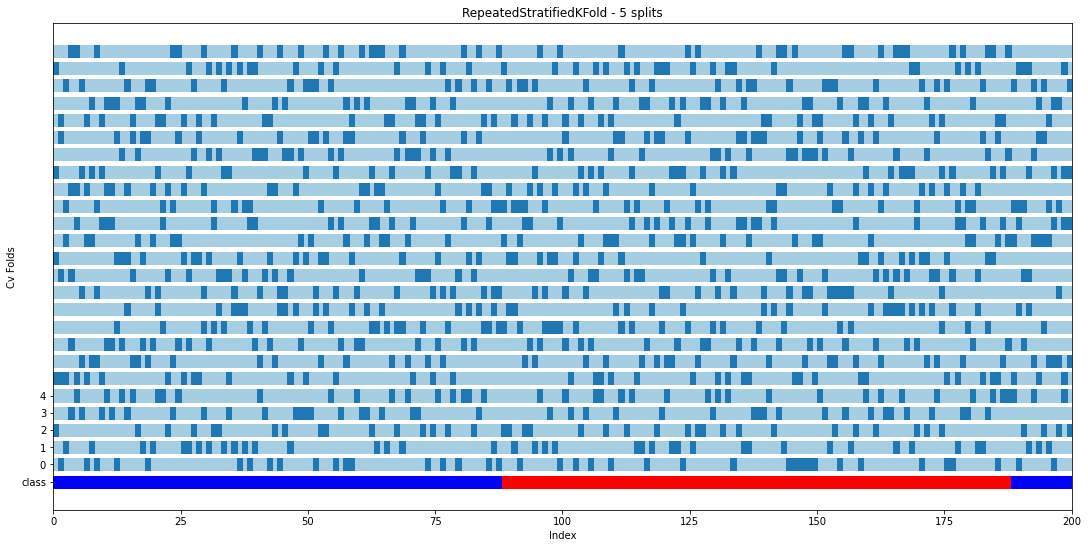

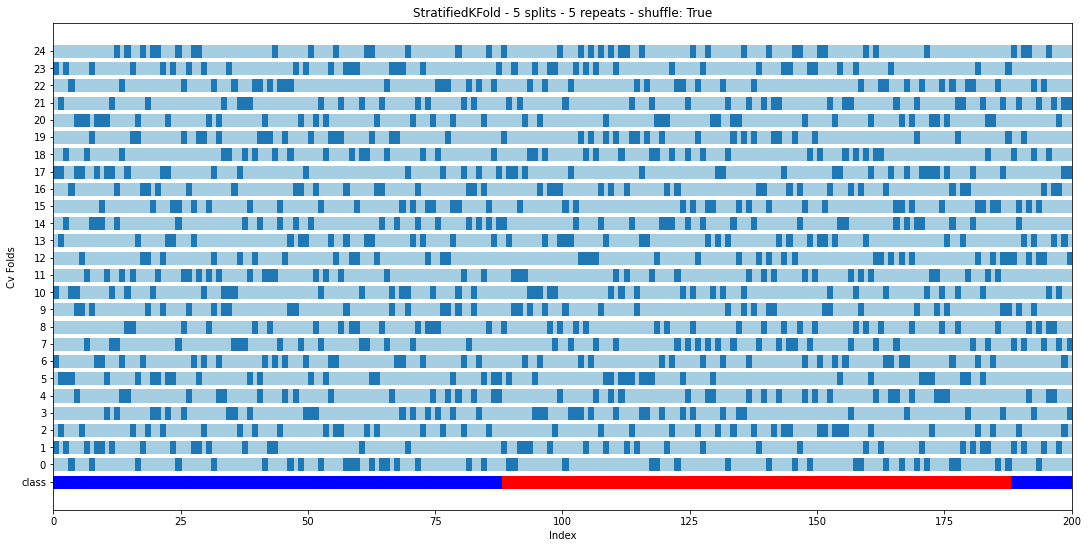

In [34]:
def plot_cv_folds_repeat(cv, X, y, n_splits):
    ax = f.get_ax(1, 2)
    
    point_width = 1
    line_height = 0.7

    idx = y.loc[(y == 0)].index
    x_ = list(zip(idx, [point_width] * len(idx)))
    ax.broken_barh(x_, (-1 - line_height/2, line_height), color='r', label=f'Class 0')

    idx = y.loc[(y == 1)].index
    x_ = list(zip(idx, [point_width] * len(idx)))
    ax.broken_barh(x_, (-1 - line_height/2, line_height), color='b', label=f'Class 1')
    
    repeat = 5
    for r in range(repeat):
        for i_fold, (idx_train, idx_test) in enumerate(cv.split(X=X, y=y)):
            idx = idx_train
            x_ = list(zip(idx, [point_width] * len(idx)))
            ax.broken_barh(x_, (r*n_splits + i_fold-line_height/2, line_height), color=plt.cm.Paired.colors[0], label=f'train')

            idx = idx_test
            x_ = list(zip(idx, [point_width] * len(idx)))
            ax.broken_barh(x_, (r*n_splits + i_fold-line_height/2, line_height), color=plt.cm.Paired.colors[1], label=f'test')
     
    ax.set(
        yticks = list(range(-1, n_splits*repeat)),
        yticklabels = ["class"] + list(range(n_splits*repeat)),
        xlim=[0, len(X)],
        xlabel = 'Index',
        ylabel = 'Cv Folds',
    )
    # ax.legend()
    ax.set_title(f'{cv.__class__.__name__} - {n_splits} splits - {repeat} repeats - shuffle: {cv.shuffle | False}')

# axs = f.get_axes(3, 1, 1, 2)

# plot_cv_folds(StratifiedKFold(5), X, y, 5)

plot_cv_folds(RepeatedStratifiedKFold(n_splits=5, n_repeats=5), X, y, 5)
plot_cv_folds_repeat(StratifiedKFold(5, shuffle=True), X, y, 5)

In [44]:
a = StratifiedKFold()
a.n_splits
b = RepeatedStratifiedKFold()
b.get_n_splits()

5

50

## Exclude repeats

In [96]:
def plot_cv_folds2(cv, X, y, n_splits):
    ax = f.get_ax(1, 3)
    
    point_width = 1
    line_height = 0.7
    
    fold_count = 0
    
    for i_fold, (idx_train, idx_test) in enumerate(cv.split(X=X, y=y)):
        fold_count += 1
        idx = idx_train
        x_ = list(zip(idx, [point_width] * len(idx)))
        ax.broken_barh(x_, (i_fold-line_height/2, line_height), facecolor=plt.cm.Paired.colors[0], label=f'train', alpha=1)
        
        idx = idx_test
        x_ = list(zip(idx, [point_width] * len(idx)))
        ax.broken_barh(x_, (i_fold-line_height/2, line_height), facecolor=plt.cm.Paired.colors[1], label=f'test', alpha=1)

    idx = y.loc[(y == 0)].index
    x_ = list(zip(idx, [point_width] * len(idx)))
    ax.broken_barh(x_, (-1 - line_height/2, line_height), color='r', label=f'Class 0')

    idx = y.loc[(y == 1)].index
    x_ = list(zip(idx, [point_width] * len(idx)))
    ax.broken_barh(x_, (-1 - line_height/2, line_height), color='b', label=f'Class 1')

    
    ax.set(
        yticks = list(range(-1, fold_count)),
        yticklabels = ["class"] + list(range(fold_count)),
        # xlim=[0, len(X)],
        xlabel = 'Index',
        ylabel = 'Cv Folds',
    )
    # ax.legend()
    # ax.set_title(f'{cv.__class__.__name__} - {n_splits} splits - shuffle: {cv.shuffle | False}')
    ax.set_title(f'{cv.__class__.__name__} - {fold_count} Folds')

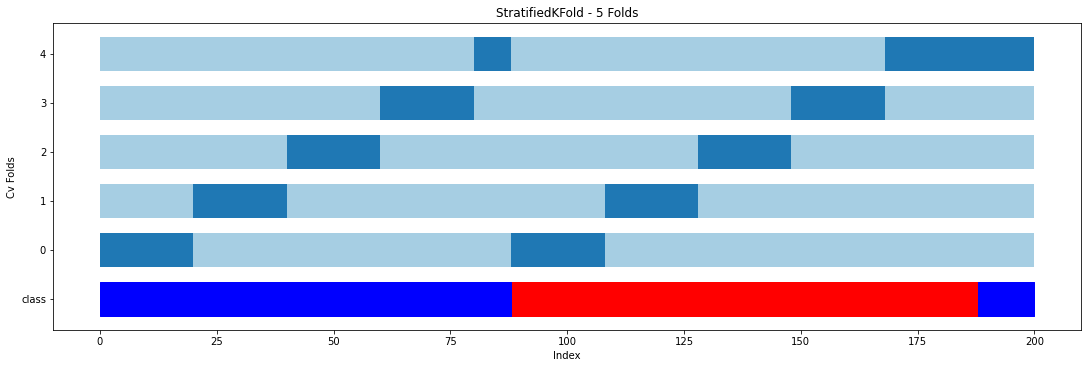

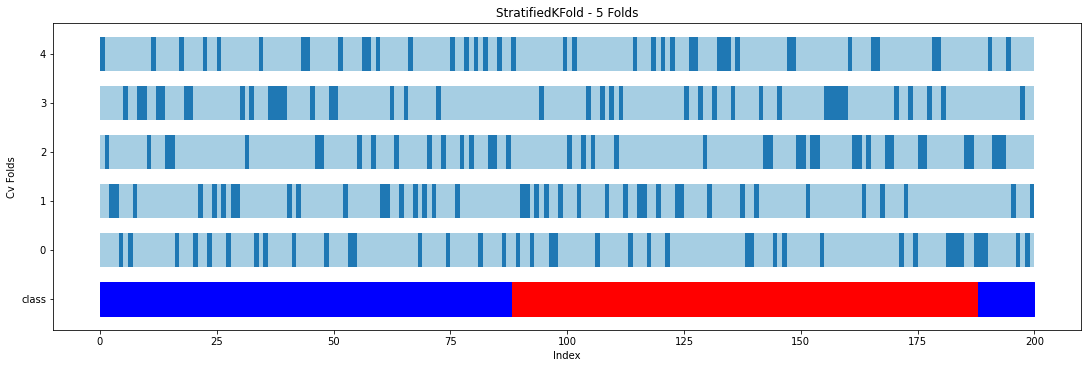

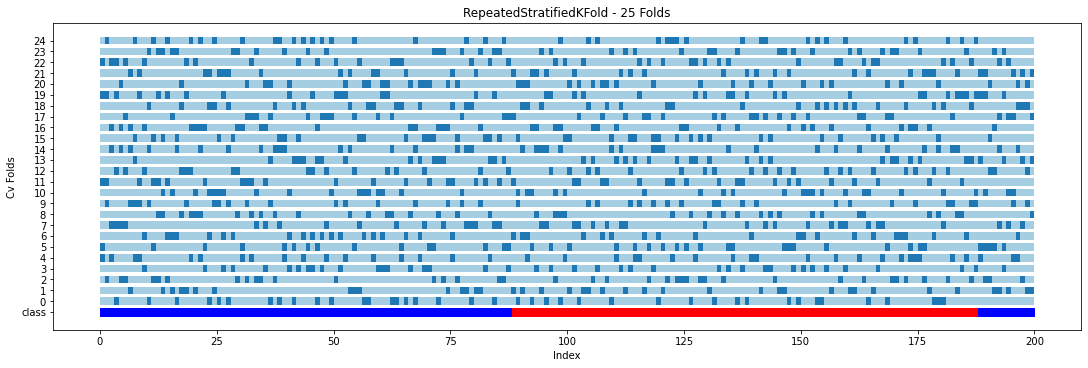

In [97]:
plot_cv_folds2(
    StratifiedKFold(5), X, y, 5)

plot_cv_folds2(
    StratifiedKFold(5, shuffle=True), X, y, 5)

plot_cv_folds2(
    RepeatedStratifiedKFold(n_splits=5, n_repeats=5), X, y, 5)